In [1]:
import os
from tqdm import tqdm
from time import time
import pandas as pd
from qiskit.visualization import circuit_drawer
from qiskit import QuantumCircuit, Aer, transpile, QuantumRegister, ClassicalRegister
from qiskit.providers.aer import AerSimulator
from qiskit.quantum_info import StabilizerState, Pauli, DensityMatrix, Statevector, Operator
from qiskit.quantum_info.operators.symplectic.clifford import Clifford
from qiskit.circuit.quantumcircuitdata import CircuitInstruction
from qiskit.circuit.operation import Operation
from qiskit_aer import aerbackend, aerprovider
from qiskit.providers.aer.noise import NoiseModel, depolarizing_error, QuantumError, pauli_error
import matplotlib.pyplot as plt
import sys
import numpy as np
from qiskit.quantum_info import state_fidelity
np.random.seed(239)
import seaborn as sns
directory_path='QASMBench/small/'

In [2]:
native_gates = ['rz', 'cz', 'rx', 'ry']

In [3]:
def remove_conditions(circuit : QuantumCircuit):
    circ = QuantumCircuit(*circuit.cregs, *circuit.qregs)
    circ.name = circuit.name
    for instr, qargs, cargs in circuit.data:
        if (instr.condition is None):
            circ.append(instr, qargs, cargs)
    return circ

In [4]:
def round_to_pi2(angle):
    normalized_angle = angle % (2 * np.pi)
    rounded_angle = round(normalized_angle / (np.pi / 2)) * (np.pi / 2)
    return rounded_angle

def round_angles(circuit):
    new_circuit = QuantumCircuit(*circuit.qregs, *circuit.cregs)
    angle = 0
    for instr, qargs, cargs in circuit.data:
        if (instr.name == 'rz'):
            angle = round_to_pi2(instr.params[0])
            new_circuit.rz(angle, qargs)
        elif(instr.name == 'rx'):
            angle = round_to_pi2(instr.params[0])
            new_circuit.rx(angle, qargs)
        elif(instr.name == 'ry'):
            angle = round_to_pi2(instr.params[0])
            new_circuit.ry(angle, qargs)
        else:
            new_circuit.append(instr, qargs, cargs)
    return new_circuit

In [5]:
def get_duration_prob(name, params, T2=2000, T_RX=100, T_RZ=30, T_CZ=15): #mks
    if (name == 'rx' or name == 'ry'):
        theta = params[0] % (2 * np.pi)
        return theta / np.pi * 5, 1 - np.exp(-theta / T_RX / np.pi)
    if (name == 'rz'):
        theta = params[0] % (2 * np.pi)
        return theta / np.pi * 0.5, 1 - np.exp(-theta / T_RZ / np.pi)
    if (name == 'cz'):
        return 2, 1 - np.exp(-2. / T_CZ)
    if (name == 'id'):
        t = params[0]
        return t, 1 - np.exp(-t/T2)
    return None

def make_native_circuit(t_circ : QuantumCircuit, opt_level=0, T2=2000, T_RX=100, T_RZ=30, T_CZ=15) -> (QuantumCircuit, dict):
    circuit = transpile(t_circ, basis_gates=native_gates, optimization_level=opt_level)
    time = 0.0 #mks
    new_circuit = QuantumCircuit(*circuit.qregs, *circuit.cregs)
    new_circuit.name = t_circ.name
    data = []
    num_instr = 0
    times = np.zeros(circuit.num_qubits)
    for instr, qargs, cargs in circuit.data:
        if (instr.name in native_gates):
            for qarg in qargs:
                index = circuit.find_bit(qarg).index     
                # id gate:
                if times[index] != time:
                    new_circuit.id(qarg)
                    duration_id, prob_id = get_duration_prob('id', [time - times[index]], T2=T2)
                    data.append(prob_id)
                    times[index] = time
            # gate:
            duration, prob = get_duration_prob(instr.name, instr.params, T2=T2, T_RX=T_RX, T_RZ=T_RZ, T_CZ=T_CZ)
            new_circuit.append(instr, qargs, cargs)
            data.append(prob)
            time = time + duration
            for qarg in qargs:
                times[index] = time
    for qreg in new_circuit.qregs:
        for qarg in qreg:
            index = new_circuit.find_bit(qarg).index
            if times[index] != time:
                new_circuit.id(qarg)
                duration, prob = get_duration_prob('id', [time - times[index]], T2=T2)
                data.append(prob)        
    return new_circuit, data

In [6]:
paths = []
for root, dirs, files in os.walk(directory_path):
    for dir_name in dirs:
        qasm_file_path = os.path.join(directory_path, dir_name, f"{dir_name}.qasm")
        number_at_end = int(''.join(filter(str.isdigit, dir_name)))
        if os.path.exists(qasm_file_path) and number_at_end <= 7:
            paths.append(qasm_file_path)
def noisy_circuit(circuit, data):
    new_circuit = QuantumCircuit(*circuit.qregs, *circuit.cregs)
    assert(len(circuit.data) == len(data))
    for i, (instr, qargs, cargs) in enumerate(circuit.data):
        prob_error = data[i]
        choice = np.random.choice(['Z', 'I'], p=[prob_error, 1 - prob_error])
        new_circuit.append(instr, qargs, cargs)
        for qubit in qargs:
            if (choice == 'Z'):
                new_circuit.z(qubit)
    return new_circuit

In [7]:
def make_clifford_data(circ : QuantumCircuit, data : list = None, round_angle : bool =False):
    if not round_angle or not data:
        c, data = make_native_circuit(round_angles(circ), opt_level=0)
    else:
        c = circ
    new_circuit = QuantumCircuit(*c.qregs, *c.cregs)
    new_data = []
    for i, (instr, qargs, cargs) in enumerate(c.data):
        if (instr.name == 'rz'):
            angle = instr.params[0]
            if (angle == np.pi / 2):
                new_circuit.s(qargs)
            elif (angle == np.pi):
                new_circuit.z(qargs)
            elif (angle == 3 * np.pi / 2):
                new_circuit.s(qargs)
                new_circuit.z(qargs)
                new_data.append(0)
            else:
                new_circuit.id(qargs)
        elif (instr.name == 'rx'):
            angle = instr.params[0]
            if (angle == np.pi / 2):
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_circuit.h(qargs)
                new_data.append(0)
                new_data.append(0)
            elif (angle == np.pi):
                new_circuit.x(qargs)
            elif (angle == 3 * np.pi / 2):
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_circuit.h(qargs)
                new_circuit.x(qargs)
                new_data.append(0)
                new_data.append(0)
                new_data.append(0)
            else:
                new_circuit.id(qargs)
        elif (instr.name == 'ry'):
            angle = instr.params[0]
            if (angle == np.pi / 2):
                new_circuit.sdg(qargs)
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_data.append(0)
                new_data.append(0)
                new_data.append(0)
                new_data.append(0)
            elif (angle == np.pi):
                new_circuit.y(qargs)
            elif (angle == 3 * np.pi / 2):
                new_circuit.sdg(qargs)
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_circuit.y(qargs)
                new_data.append(0)
                new_data.append(0)
                new_data.append(0)
                new_data.append(0)
                new_data.append(0)
            else:
                new_circuit.id(qargs)
        else:
            new_circuit.append(instr, qargs, cargs)
        new_data.append(data[i])
    return new_circuit, new_data

In [35]:
def make_clifford(circ : QuantumCircuit, round_angle : bool =False) -> Clifford:
    if not round_angle:
        transpile_circuit = round_angles(circ)
    else:
        transpile_circuit = circ
    new_circuit = QuantumCircuit(*transpile_circuit.qregs, *transpile_circuit.cregs)
    for instr, qargs, cargs in transpile_circuit.data:
        if (instr.name == 'rz'):
            angle = instr.params[0]
            if (angle == np.pi / 2):
                new_circuit.s(qargs)
            elif (angle == np.pi):
                new_circuit.z(qargs)
            elif (angle == 3 * np.pi / 2):
                new_circuit.s(qargs)
                new_circuit.z(qargs)
        elif (instr.name == 'rx'):
            angle = instr.params[0]
            if (angle == np.pi / 2):
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_circuit.h(qargs)
            elif (angle == np.pi):
                new_circuit.x(qargs)
            elif (angle == 3 * np.pi / 2):
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_circuit.h(qargs)
                new_circuit.x(qargs)
        elif (instr.name == 'ry'):
            angle = instr.params[0]
            if (angle == np.pi / 2):
                new_circuit.sdg(qargs)
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_circuit.h(qargs)
                new_circuit.s(qargs)
            elif (angle == np.pi):
                new_circuit.y(qargs)
            elif (angle == 3 * np.pi / 2):
                new_circuit.sdg(qargs)
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_circuit.h(qargs)
                new_circuit.s(qargs)
                new_circuit.y(qargs)
        else:
            new_circuit.append(instr, qargs, cargs)
    new_circuit.save_clifford()
    aer = AerSimulator(method='stabilizer')
    result = aer.run(new_circuit, shots=1).result().data()['clifford']
    return result, new_circuit

In [9]:
circuits = []
for i, path in enumerate(paths):
    
    filename = path.split('/')[-1]
    print(i, filename)
    sys.stdout.flush()
    circuit = QuantumCircuit.from_qasm_file(path)
    circuit.name = filename[:-5]
    circuit = remove_conditions(circuit)
    circuit.remove_final_measurements()
    #circuit = round_angles(circuit)
    circuits.append(make_native_circuit(circuit, opt_level=2))

0 qft_n4.qasm
1 fredkin_n3.qasm
2 dnn_n2.qasm
3 qec_sm_n5.qasm
4 deutsch_n2.qasm
5 bell_n4.qasm
6 teleportation_n3.qasm
7 shor_n5.qasm
8 wstate_n3.qasm
9 vqe_uccsd_n4.qasm
10 lpn_n5.qasm
11 sat_n7.qasm
12 hhl_n7.qasm
13 qrng_n4.qasm
14 qaoa_n6.qasm
15 pea_n5.qasm
16 toffoli_n3.qasm
17 inverseqft_n4.qasm
18 variational_n4.qasm
19 linearsolver_n3.qasm
20 grover_n2.qasm
21 basis_change_n3.qasm
22 adder_n4.qasm
23 vqe_n4.qasm
24 basis_trotter_n4.qasm
25 simon_n6.qasm
26 quantumwalks_n2.qasm
27 vqe_uccsd_n6.qasm
28 cat_state_n4.qasm
29 qaoa_n3.qasm
30 iswap_n2.qasm
31 qec_en_n5.qasm
32 ipea_n2.qasm


In [10]:
def fidelity_clifford_long(clifford1 : Clifford, clifford2 : Clifford) -> complex:
    d = 2 ** clifford1.num_qubits
    initial_state = np.zeros(d)
    initial_state[0] = 1
    initial_state = initial_state.reshape(d, 1)
    state1 = clifford1.to_matrix() @ initial_state
    state2 = clifford2.to_matrix() @ initial_state
    return state_fidelity(state1, state2)

In [11]:
#to plot circuits
#plt.figure(figsize=(100, 5))
# circ, d = make_native_circuit(round_angles(circuits[12][0]), opt_level=0)
# n_circ = noisy_circuit(circ, d)
# fig, axs = plt.subplots(3, 1, figsize=(100, 8), gridspec_kw={'hspace': 0.001})
# circuit_drawer(circuits[12][0], output='mpl', style='iqp', ax=axs[0], scale=2, fold=len(circuits[12][0].data))
# circuit_drawer(circ, output='mpl', style='clifford', ax=axs[1], scale=2, fold=len(circuits[12][0].data))
# circuit_drawer(n_circ, output='mpl', style='clifford', ax=axs[2], scale=2, fold=len(n_circ.data))
# plt.savefig('circ12.pdf')


' '

In [73]:
#to check (measuring -> measure = True)
def fidelity_density_matrix(circuit :QuantumCircuit, T2=2000, T_RX=100, T_RZ=30, T_CZ=15, measure=True):
    circ, d = make_native_circuit(circuit, opt_level=0, T2=T2, T_RX=T_RX, T_RZ=T_RZ, T_CZ=T_CZ)
    noiseless_circ = circ.copy()
    noiseless_circ.save_density_matrix()
    g = AerSimulator(method='density_matrix')
    rho1 = np.array(g.run(noiseless_circ, shots=1, noise_model=None, optimization_level=0).result().data()['density_matrix'])
    

    rho2 = np.zeros_like(rho1)
    rho2[0, 0] = 1
    for i, (instr, qargs, cargs) in enumerate(circ.data):
        qc = QuantumCircuit(*circ.qregs, *circ.cregs)
        qc.append(instr, qargs, cargs)
        U = Operator(qc).to_matrix()
        qc = QuantumCircuit(*circ.qregs, *circ.cregs)
        qc.z(qargs)
        Z = Operator(qc).to_matrix()
        rho2 = U @ rho2 @ U.T.conj()
        prob = d[i]
        #rho2 = (1 - prob) * rho2 + prob * np.eye(2 ** circ.num_qubits) / (2 ** circ.num_qubits)
        rho2 = (1 - prob) * rho2 + prob * Z @ rho2 @ Z
    if measure:
        return state_fidelity(np.diag(rho1.diagonal()), np.diag(rho2.diagonal()))
    else:
        return state_fidelity(rho1, rho2)

In [71]:
#to check 2 
def fidelity_long_shots_2(circuit : QuantumCircuit, shots=1000):
    circ, d = make_native_circuit(circuit)
    noiseless_circ = circ.copy()
    noiseless_circ.save_statevector()
    g = AerSimulator(method='statevector')
    phi1 = np.array(g.run(noiseless_circ, shots=1, noise_model=None, optimization_level=0).result().get_statevector(noiseless_circ))
    fs = []
    for _ in tqdm(range(shots)):
        noisy_circ = noisy_circuit(circ, d)
        noisy_circ.save_statevector()
        phi2 = np.array(g.run(noisy_circ, shots=1, noise_model=None, optimization_level=0).result().get_statevector(noisy_circ))
        fs.append(state_fidelity(phi1, phi2))

    return np.mean(fs)

In [15]:
def clifford_simulate(circ :  QuantumCircuit) -> Clifford:
    circuit = circ.copy()
    circuit.save_clifford()
    aer = AerSimulator(method='stabilizer')
    result = aer.run(circuit, shots=1).result().data()['clifford']
    return result

In [54]:
def fidelity(circuit : QuantumCircuit, shots=1000):
    circ, d = make_native_circuit(round_angles(circuit), opt_level=0)
    clifford1, c = make_clifford(circ, round_angle=True)
    fs = []
    clifford2 = 0
    r = 2 ** clifford1.num_qubits
    initial_state = np.zeros(r)
    initial_state[0] = 1
    initial_state = initial_state.reshape(r, 1)
    state1 = clifford1.to_matrix() @ initial_state
    for _ in tqdm(range(shots)):
    #for _ in range(shots):
        noisy = noisy_circuit(circ, d)
        clifford2, c = make_clifford(noisy, round_angle=True)
        state2 = clifford2.to_matrix() @ initial_state
        fs.append(state_fidelity(state1, state2))
    return np.mean(fs)

In [55]:
def fidelity2(circuit : QuantumCircuit, shots=1000):
    circ, d = make_clifford_data(circuit)
    clifford1 = clifford_simulate(circ)
    fs = []
    clifford2 = 0
    noisies = []
    for _ in tqdm(range(shots)):
    #for _ in range(shots):
        noisy = noisy_circuit(circ, d)
        noisy.save_clifford()
        noisies.append(noisy)
    g = AerSimulator(method='stabilizer')
    result = g.run(noisies, shots=1).result()#.data()['clifford']
    d = 2 ** clifford1.num_qubits
    initial_state = np.zeros(d)
    initial_state[0] = 1
    initial_state = initial_state.reshape(d, 1)
    state1 = clifford1.to_matrix() @ initial_state
    for i in tqdm(range(shots)):
        clifford2 = result.data(i)['clifford']
        state2 = clifford2.to_matrix() @ initial_state
        fs.append(state_fidelity(state1, state2))
    return np.mean(fs)

In [40]:
from collections import defaultdict

In [78]:
def fidelity_measuring(circuit : QuantumCircuit, shots=1000):
    c, d = make_clifford_data(circuit)
    c.measure_all()
    g = AerSimulator(method='stabilizer')
    result1 = dict(g.run(c, noise_model=None, shots=shots).result().data())['counts']
    noisies = []
    result2 = defaultdict(int)
    c.remove_final_measurements()
    for _ in tqdm(range(shots)):
        noisy = noisy_circuit(c, d)
        noisy.measure_all()
        noisies.append(noisy)
    results = g.run(noisies, noise_model=None, shots=1).result()
    for i in range(shots):
        res = list(results.data(i)['counts'])[0]
        result2[res] += 1
    df = pd.DataFrame([result1, result2]).T
    df = df.fillna(0).astype(int)
    np.sum(np.sqrt(df[0] * df[1]))/shots
    return (np.sum(np.sqrt(df[0] * df[1])) / shots) ** 2

In [56]:
t = time()
fidelity(round_angles(circuits[12][0]))
time() - t

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:30<00:00, 11.03it/s]


90.77504920959473

In [57]:
t = time()
fidelity2(round_angles(circuits[12][0]))
time() - t

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 32.04it/s]


62.58219885826111

In [66]:
t = time()
f = fidelity_measuring(round_angles(circuits[12][0]))
time() - t

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1193258.61it/s]


28.95241904258728

In [79]:
fidelities = []
for circuit, d in circuits:
    fidelities.append({
        'circuit' : circuit.name,
        'fidelity_clifford' : fidelity_measuring(circuit),
        'fidelity_original' : fidelity_density_matrix(circuit, measure=True)
    })
    print(fidelities[-1])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 756.09it/s]


{'circuit': 'qft_n4', 'fidelity_clifford': 0.9908762494398029, 'fidelity_original': 0.9999999999999996}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 782.96it/s]


{'circuit': 'fredkin_n3', 'fidelity_clifford': 0.49300000000000005, 'fidelity_original': 0.39106405550761647}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 120.33it/s]


{'circuit': 'dnn_n2', 'fidelity_clifford': 0.9989345554470347, 'fidelity_original': 0.8639664379803735}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1519.25it/s]


{'circuit': 'qec_sm_n5', 'fidelity_clifford': 0.708, 'fidelity_original': 0.5977697568146965}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2701.53it/s]


{'circuit': 'deutsch_n2', 'fidelity_clifford': 0.8835426350048214, 'fidelity_original': 0.8614973460222624}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 562.34it/s]


{'circuit': 'bell_n4', 'fidelity_clifford': 0.5731606984561499, 'fidelity_original': 0.8924242507246247}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1936.99it/s]


{'circuit': 'teleportation_n3', 'fidelity_clifford': 0.858113745331296, 'fidelity_original': 0.9614945039644334}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 257.82it/s]


{'circuit': 'shor_n5', 'fidelity_clifford': 0.4089017277280061, 'fidelity_original': 0.1876423780842681}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 974.60it/s]


{'circuit': 'wstate_n3', 'fidelity_clifford': 0.9997691666947234, 'fidelity_original': 0.5754651480864622}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 82.33it/s]


{'circuit': 'vqe_uccsd_n4', 'fidelity_clifford': 0.25061713030738375, 'fidelity_original': 0.3932136604077383}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1552.60it/s]


{'circuit': 'lpn_n5', 'fidelity_clifford': 0.7469946054890377, 'fidelity_original': 0.7370431218829469}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 158.42it/s]


{'circuit': 'sat_n7', 'fidelity_clifford': 0.4800419510608801, 'fidelity_original': 0.07246306984790904}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 48.04it/s]


{'circuit': 'hhl_n7', 'fidelity_clifford': 0.11871041607725456, 'fidelity_original': 0.03540532150908307}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1732.17it/s]


{'circuit': 'qrng_n4', 'fidelity_clifford': 0.9885715270578909, 'fidelity_original': 0.9999999999999998}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 94.15it/s]


{'circuit': 'qaoa_n6', 'fidelity_clifford': 0.9634210973090078, 'fidelity_original': 0.9061042732924427}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 225.33it/s]


{'circuit': 'pea_n5', 'fidelity_clifford': 0.19555559999918165, 'fidelity_original': 0.05270148069116053}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1258.56it/s]


{'circuit': 'toffoli_n3', 'fidelity_clifford': 0.7960000000000002, 'fidelity_original': 0.585475931786248}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1034.33it/s]


{'circuit': 'inverseqft_n4', 'fidelity_clifford': 0.9380000000000001, 'fidelity_original': 0.9419543197774449}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 389.30it/s]


{'circuit': 'variational_n4', 'fidelity_clifford': 0.29300000000000004, 'fidelity_original': 0.377861527669024}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 968.10it/s]


{'circuit': 'linearsolver_n3', 'fidelity_clifford': 0.5199999999999999, 'fidelity_original': 0.6675204425182433}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1390.47it/s]


{'circuit': 'grover_n2', 'fidelity_clifford': 0.706, 'fidelity_original': 0.7186563021219056}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 498.34it/s]


{'circuit': 'basis_change_n3', 'fidelity_clifford': 0.317, 'fidelity_original': 0.24817658409519283}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 488.95it/s]


{'circuit': 'adder_n4', 'fidelity_clifford': 0.4695219125574892, 'fidelity_original': 0.26212470962667134}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 413.21it/s]


{'circuit': 'vqe_n4', 'fidelity_clifford': 0.9920695224033078, 'fidelity_original': 0.8461734599402964}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:38<00:00, 10.14it/s]


{'circuit': 'basis_trotter_n4', 'fidelity_clifford': 0.067, 'fidelity_original': 0.06250002962237237}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 457.84it/s]


{'circuit': 'simon_n6', 'fidelity_clifford': 0.37164474119823526, 'fidelity_original': 0.529663124622572}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1121.24it/s]


{'circuit': 'quantumwalks_n2', 'fidelity_clifford': 0.7447822816190907, 'fidelity_original': 0.6657662230914415}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:06<00:00,  7.93it/s]


{'circuit': 'vqe_uccsd_n6', 'fidelity_clifford': 0.5162178333387005, 'fidelity_original': 0.4305812880931189}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1054.13it/s]


{'circuit': 'cat_state_n4', 'fidelity_clifford': 0.6129710874418843, 'fidelity_original': 0.6450606722580624}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1213.65it/s]


{'circuit': 'qaoa_n3', 'fidelity_clifford': 0.9972339653388418, 'fidelity_original': 0.9620671661597635}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1484.24it/s]


{'circuit': 'iswap_n2', 'fidelity_clifford': 0.703, 'fidelity_original': 0.7100490734194926}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 657.29it/s]


{'circuit': 'qec_en_n5', 'fidelity_clifford': 0.48899999999999993, 'fidelity_original': 0.26948616025509664}


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 303.04it/s]


{'circuit': 'ipea_n2', 'fidelity_clifford': 0.5029747766354519, 'fidelity_original': 0.48121693288009026}


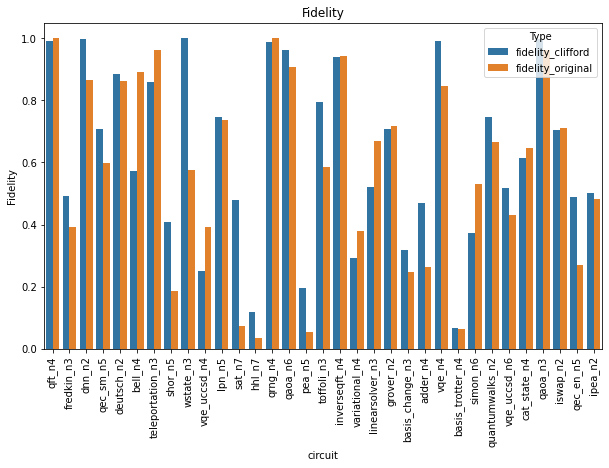

In [80]:
df = pd.DataFrame(fidelities)
plt.figure(figsize=(10, 6))
sns.barplot(data=df.melt('circuit', var_name='Type', value_name='Fidelity'), x='circuit', y='Fidelity', hue='Type')
plt.title('Fidelity')
plt.xticks(rotation=90)
plt.show()